In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,r2_score
import xgboost as xgb
import warnings
import joblib
warnings.filterwarnings('ignore')

In [74]:
clusterData = pd.read_csv("data.csv")
cluster = clusterData.cluster

In [75]:
data = pd.read_csv("Medicalpremium.csv")

In [76]:
data["cluster"] = cluster

In [77]:
df = data.copy()

In [78]:
subset_selection_features = ["Age", "AnyTransplants", "AnyChronicDiseases", "HistoryOfCancerInFamily",
                             "NumberOfMajorSurgeries", "BMI"]

In [79]:
def mape(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    print(f"MAPE for data: {mape:.2f}%")

In [80]:
def eval(model, name):
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))

    mape_test = mean_absolute_percentage_error(y_test, pred_test)*100
    mape_train = mean_absolute_percentage_error(y_train, pred_train)*100

    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=cv)
    scores = np.sqrt(-scores)
    cv_mean = np.mean(scores)
    cv_std = np.std(scores)

    row = {'model': name,
           'test_rmse': rmse_test,
           'train_rmse': rmse_train,
           'test_mape': mape_test,
           'train_mape': mape_train,
           'cv_rmse': cv_mean,
           'cv_rmse_std': cv_std}
    return row

In [81]:
def upsample(x, y, cls, nSamples, category):
    sample_z = resample(z[z[category] == cls], n_samples=nSamples, replace=True, random_state=42)
    z = pd.concat([z[z[category] != cls], sample_X])
    z.reset_index(drop=True, inplace=True)

In [82]:
summary = pd.DataFrame(columns=['model',
           'test_rmse',
           'train_rmse',
           'test_mape',
           'train_mape',
           'cv_rmse',
           'cv_rmse_std'])

# Custom transformers

In [83]:
class BMI(BaseEstimator, TransformerMixin):
    def __init__(self, bmi=True, bmiCat=True, dropbmi=False):
        self.bmi = bmi
        self.bmiCat = bmiCat
        self.dropbmi = dropbmi

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.bmi:
            X["BMI"] = X["Weight"]/(X["Height"]/100)**2
            X = X.drop(["Weight", "Height"], axis=1)
            
            if self.bmiCat:
                bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
                labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extreme']
                X["BMI_cat"] = pd.cut(X["BMI"], bins=bins, labels=labels, right=False)
                if self.dropbmi:
                    X = X.drop("BMI", axis=1)
                    return X
                else:
                    #X = X.drop(["Weight", "Height"], axis=1)
                    return X
            else:
                #X = X.drop(["Weight", "Height"], axis=1)
                return X
        else:
            return X

In [84]:
class cluster(BaseEstimator, TransformerMixin):
    def __init__(self, drop=True):
        self.drop = drop

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if (self.drop):
            X.drop("cluster", axis=1, inplace=True)
        return X

In [85]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        if (self.columns is not None):
            self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        if (self.columns is not None):
            onehot_encoded = self.encoder.transform(X[self.columns])
            feature_names = self.encoder.get_feature_names_out()
            result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
            return pd.concat([X.drop(columns=self.columns), result_df], axis=1)
        else:
            return X

In [86]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if (self.columns is None):
            num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
            self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [87]:
class featureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if (self.columns is None):
            self.columns = X.columns
        return X[self.columns]

# preprocessing

In [88]:
#dt = upsample(category= "NumberOfMajorSurgeries", cls=3, nSamples=100).transform(df.copy())
dt = df.copy()

In [89]:
X = dt.drop("PremiumPrice", axis=1)
y = dt.PremiumPrice.copy()

In [90]:
X.shape

(986, 11)

In [91]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [92]:
pipe = Pipeline([
    ('bmi', BMI(bmiCat=False)),
    ('cluster', cluster()),
    ('oneHot', oneHot()),
    ('scaler', StdScaler()),
    ('feature_selction', featureSelection())
])

In [93]:
pipe1 = clone(pipe)

In [94]:
pipe2 = clone(pipe).set_params(feature_selction__columns = subset_selection_features)

# Random Forest

In [95]:
from sklearn.ensemble import RandomForestRegressor

In [96]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [97]:
forest_reg = RandomForestRegressor(random_state=42, max_depth=6, n_estimators=300, n_jobs=-1, min_samples_leaf=2)

In [98]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [99]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [100]:
pred = forest_reg.predict(X_test)

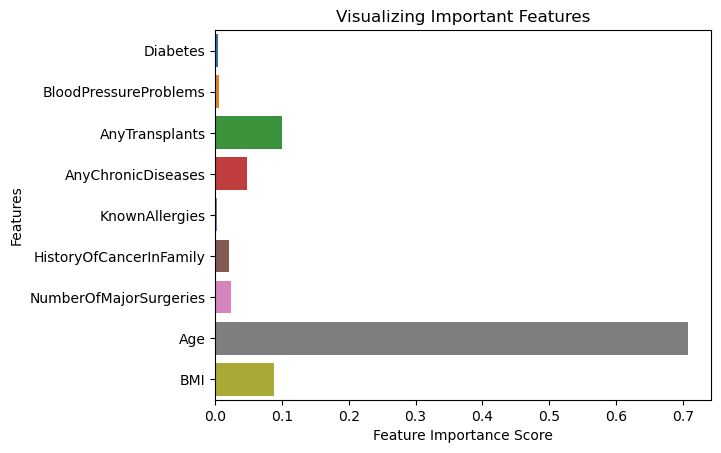

In [101]:
feature_imp1 = forest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

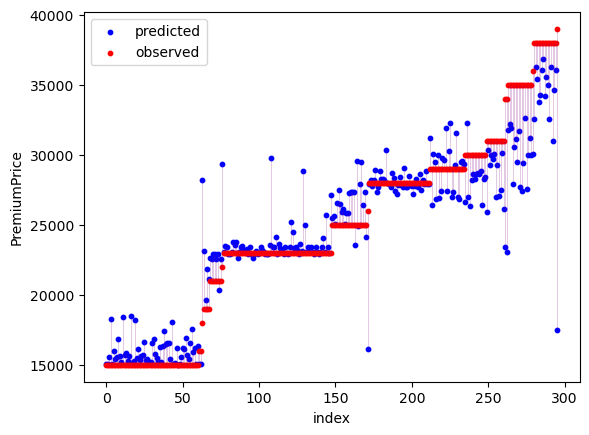

In [45]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## learning curve

In [102]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = forest_reg,
X = X_train,
y = y_train,
    cv = 5,
scoring = 'neg_mean_squared_error')

In [103]:
train_scores = np.sqrt(-train_scores)
validation_scores = np.sqrt(-validation_scores)

In [104]:
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

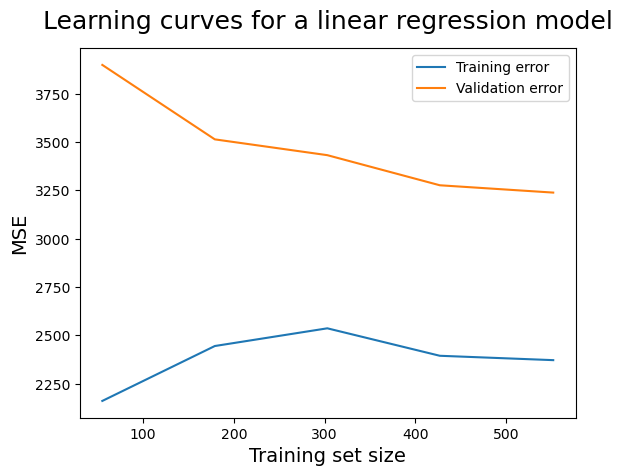

In [105]:
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [106]:
summary.loc[0] = eval(forest_reg, "random forset")

In [107]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3253.892554,368.533617


In [52]:
forest_test_r2=r2_score(y_test,pred)
forest_test_r2

0.8263584593104386

In [53]:
forest_train_r2=r2_score(y_train,forest_reg.predict(X_train))
forest_train_r2

0.841962664291091

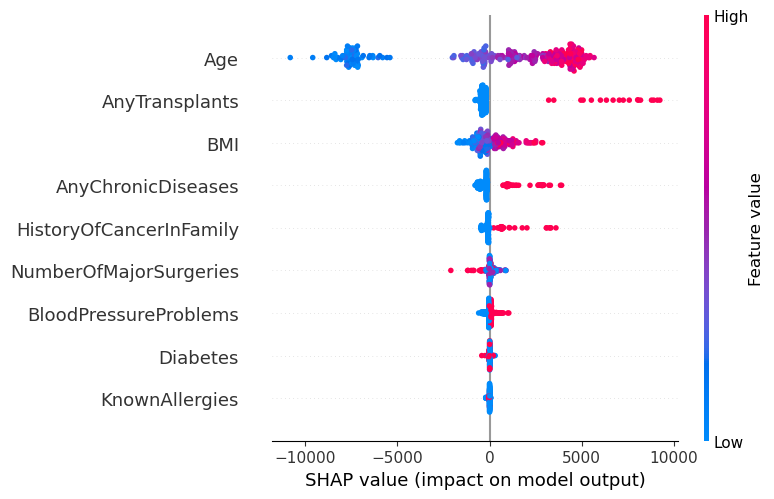

In [54]:
import shap
explainer1 = shap.TreeExplainer(forest_reg)
RF_shap_values = explainer1.shap_values(X_test)
shap.summary_plot(RF_shap_values, X_test)

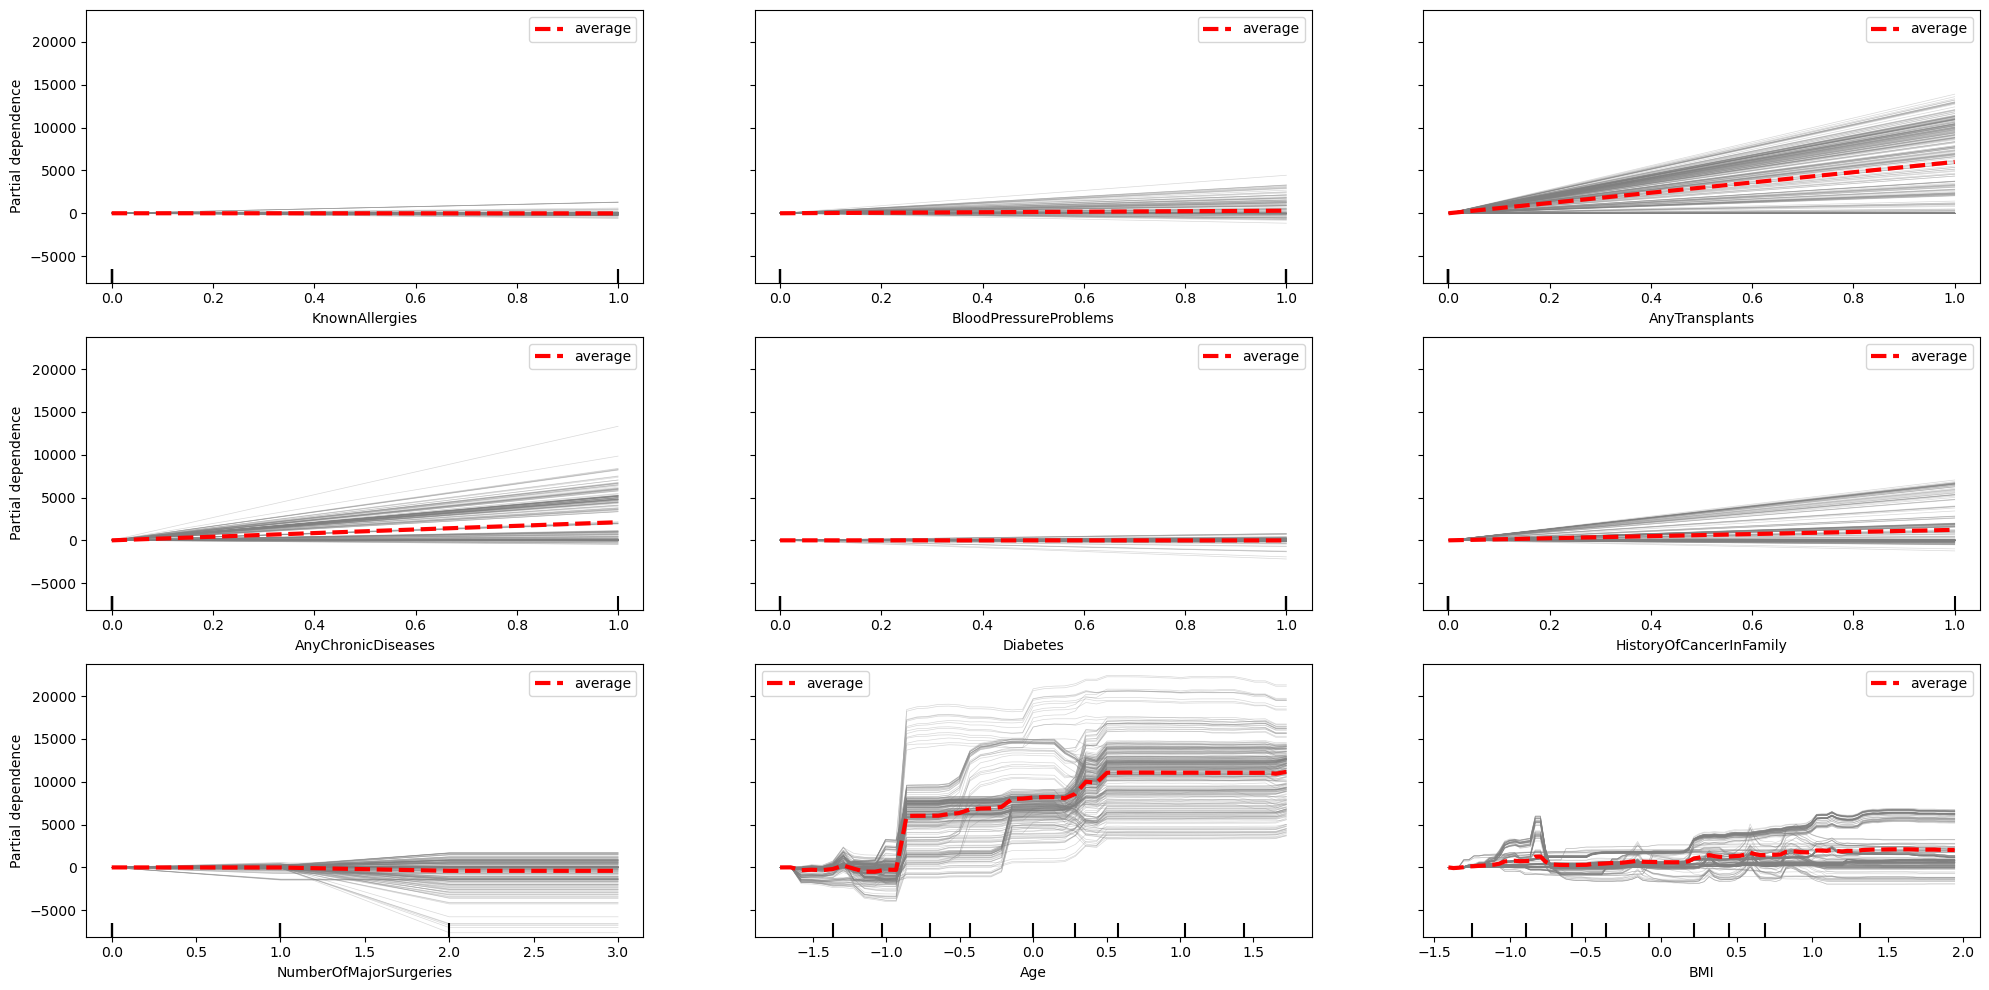

In [55]:
from sklearn.inspection import PartialDependenceDisplay
cols = X_test.columns
# Determine the 9 features with highest value for "feature importance" to draw the ICE plots.
included_features_indices = np.argpartition(forest_reg.feature_importances_, -9)[-9:]

# Plot the ICE plots.
fig, ax = plt.subplots(figsize=(20, 10))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=forest_reg,
                                            ax=ax,
                                            X=X_test,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            n_cols=3,
                                            centered= True,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})

## feature selected

In [56]:
X_train = pipe2.fit_transform(x_train.copy())
X_test = pipe2.fit_transform(x_test.copy())

In [57]:
featured_forest_reg = RandomForestRegressor(random_state=42, max_depth=5, max_features=None, min_samples_leaf=3)

In [58]:
featured_forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=None, min_samples_leaf=3,
                      random_state=42)

In [59]:
pred = featured_forest_reg.predict(X_test)

In [60]:
eval(featured_forest_reg, 'featured_forest')

{'model': 'featured_forest',
 'test_rmse': 2922.3655123244857,
 'train_rmse': 2799.9762560080862,
 'test_mape': 7.300913005585315,
 'train_mape': 6.633588479905633,
 'cv_rmse': 3353.1691072776784,
 'cv_rmse_std': 323.47578247654263}

In [61]:
forest_test_feature_r2=r2_score(y_test,pred)
forest_test_feature_r2

0.805212014254458

In [62]:
forest_train_feature_r2=r2_score(y_train,featured_forest_reg.predict(X_train))
forest_train_feature_r2

0.7871485494780515

## hyperparameter forest

### GridSearch

In [108]:
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [ ]:
X_train.shape

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 5, 6],
    'max_features': [None, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [250, 300, 350]
}

In [ ]:
forest_reg2 = RandomForestRegressor(random_state=42)

In [ ]:
forest_grid = GridSearchCV(estimator = forest_reg2, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
score = forest_grid.fit(X_train, y_train)

#### saving

In [ ]:
#joblib.dump(score, "forest2.pkl")
#score = joblib.load("forest2.pkl")

In [ ]:
best_forest_grid = score.best_estimator_

In [ ]:
score.best_params_

In [ ]:
best_forest_grid

In [ ]:
pred = best_forest_grid.predict(X_test)

In [ ]:
feature_imp1 = best_forest_grid.feature_importances_

sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [ ]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [38]:
eval(best_forest_grid, "grid forest")

NameError: name 'best_forest_grid' is not defined

In [43]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std


# Deision tree

In [109]:
from sklearn.tree import DecisionTreeRegressor

In [110]:
tree_reg = DecisionTreeRegressor(max_depth=6, random_state=42, min_samples_leaf=2, max_features=None)

In [111]:
tree_reg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [112]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [113]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=2, random_state=42)

In [114]:
pred = tree_reg.predict(X_test)

In [115]:
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=42)
for depth in range (1,10):
     tree_regressor=DecisionTreeRegressor(max_depth=depth,random_state=42, min_samples_leaf=2)
     if tree_regressor.fit(X_train,y_train).tree_.max_depth<depth:
         break
     score=np.mean(cross_val_score(tree_regressor,X_train,y_train,scoring='neg_mean_squared_error', cv=crossvalidation,n_jobs=1))
     print(depth, np.sqrt(-score))

1 4335.112021947933
2 4107.961626941019
3 3683.6339078824853
4 3601.2710609094875
5 3674.3213931460223
6 3534.4762095979872
7 3659.532331437254
8 3779.71190876779
9 3835.717644801662


In [116]:
summary.loc[1] = eval(tree_reg, "Decision tree")

In [117]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3253.892554,368.533617
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3594.299697,331.585182


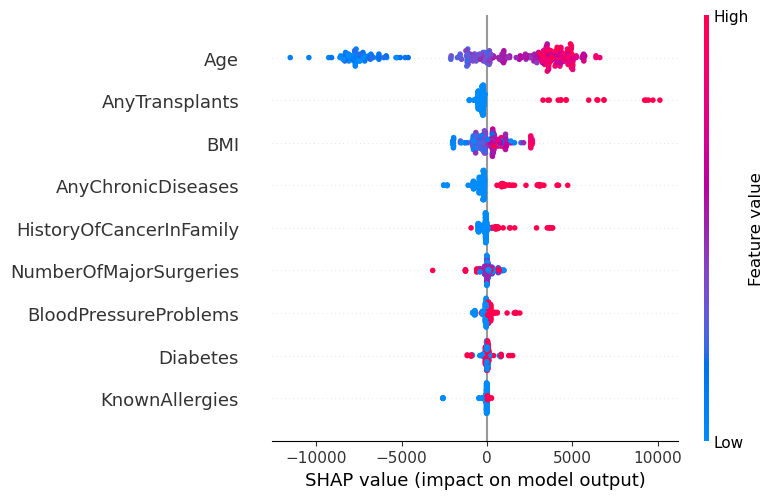

In [118]:
import shap
explainer1 = shap.TreeExplainer(tree_reg)
dec_shap_values = explainer1.shap_values(X_test)
shap.summary_plot(dec_shap_values, X_test)

# KNN

In [67]:
from sklearn.neighbors import KNeighborsRegressor

In [68]:
knn = KNeighborsRegressor(n_jobs=-1)

In [69]:
knn.fit(X_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [70]:
eval(knn, "KNN")

{'model': 'KNN',
 'test_rmse': 4134.675385147006,
 'train_rmse': 3234.7748168832445,
 'test_mape': 9.876663583807796,
 'train_mape': 8.01568793755444,
 'cv_rmse': 3973.0332913362718,
 'cv_rmse_std': 446.0364277939395}

# AdaBoost

In [119]:
from sklearn.ensemble import AdaBoostRegressor

In [120]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [121]:
Dtree = DecisionTreeRegressor(max_depth=6, random_state=42)
ada_boost = AdaBoostRegressor(n_estimators=200, base_estimator=tree_reg, learning_rate=0.001, random_state=42)

In [122]:
ada_boost

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       min_samples_leaf=2,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=200, random_state=42)

In [123]:
ada_boost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       min_samples_leaf=2,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=200, random_state=42)

In [124]:
pred = ada_boost.predict(X_test)

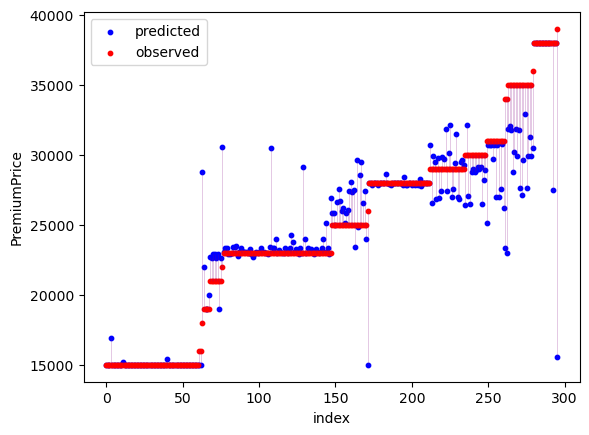

In [125]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

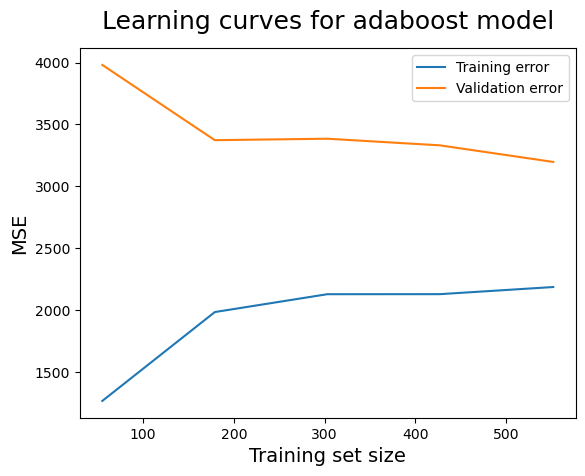

In [126]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = ada_boost,
X = X_train,
y = y_train,
    cv = 5,
scoring = 'neg_mean_squared_error')

train_scores = np.sqrt(-train_scores)
validation_scores = np.sqrt(-validation_scores)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for adaboost model', fontsize = 18, y = 1.03)
plt.legend()

In [69]:
summary.loc[2] = eval(ada_boost, "AdaBoost")
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3594.299697,331.585182
2,AdaBoost,2695.114327,2278.660585,4.234093,3.602639,3221.912535,460.283614


## grid search

In [127]:
param_grid = {
    'n_estimators': [150, 180],
    'learning_rate': [0.01, 0.001],
    #'loss': ['linear',  'square', 'exponential'],
    #'base_estimator__splitter': ["best", "random"],
    'base_estimator__max_depth': [5, 6, 7],
    'base_estimator__min_samples_leaf': [2, 3, 4],
    #'base_estimator__max_features': ['auto', 7, 6]
    
}

In [128]:
grid_ada_dtree = DecisionTreeRegressor(random_state=42)
grid_ada_boost = AdaBoostRegressor(random_state=42, base_estimator=grid_ada_dtree)

In [129]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
ada_grid = GridSearchCV(grid_ada_boost, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)

In [130]:
score = ada_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [131]:
score.best_params_

{'base_estimator__max_depth': 6,
 'base_estimator__min_samples_leaf': 3,
 'learning_rate': 0.001,
 'n_estimators': 150}

In [132]:
eval(score.best_estimator_, "grid ada boost")

{'model': 'grid ada boost',
 'test_rmse': 2688.706508370944,
 'train_rmse': 2416.7175953475903,
 'test_mape': 4.324271746856177,
 'train_mape': 3.791258290883738,
 'cv_rmse': 3183.3041189439364,
 'cv_rmse_std': 397.7581198139671}

In [133]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3253.892554,368.533617
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3594.299697,331.585182


In [134]:
best_estimator = score.best_estimator_
pred = best_estimator.predict(X_test)
adaBoost_test_r2=r2_score(y_test,pred)
adaBoost_test_r2

0.8351154757187926

In [135]:
adaBoost_train_r2=r2_score(y_train,best_estimator.predict(X_train))
adaBoost_train_r2

0.8414304750208852

  0%|          | 0/296 [00:00<?, ?it/s]

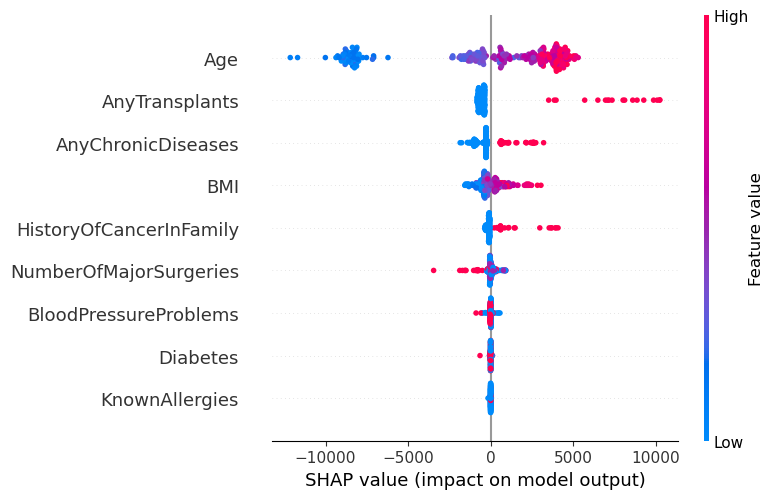

In [138]:

background_samples = shap.sample(X_test, 100) 
explainer2 = shap.KernelExplainer(ada_grid.best_estimator_.predict,background_samples)
ada_shap_values = explainer2.shap_values(X_test)
shap.summary_plot(ada_shap_values, X_test)

In [ ]:
cols = X_test.columns
# Determine the 9 features with highest value for "feature importance" to draw the ICE plots.
included_features_indices = np.argpartition(ada_grid.best_estimator_.feature_importances_, -9)[-9:]

# Plot the ICE plots.
fig, ax = plt.subplots(figsize=(20, 10))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=ada_grid.best_estimator_,
                                            ax=ax,
                                            X=X_test,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            n_cols=3,
                                            centered= True,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})

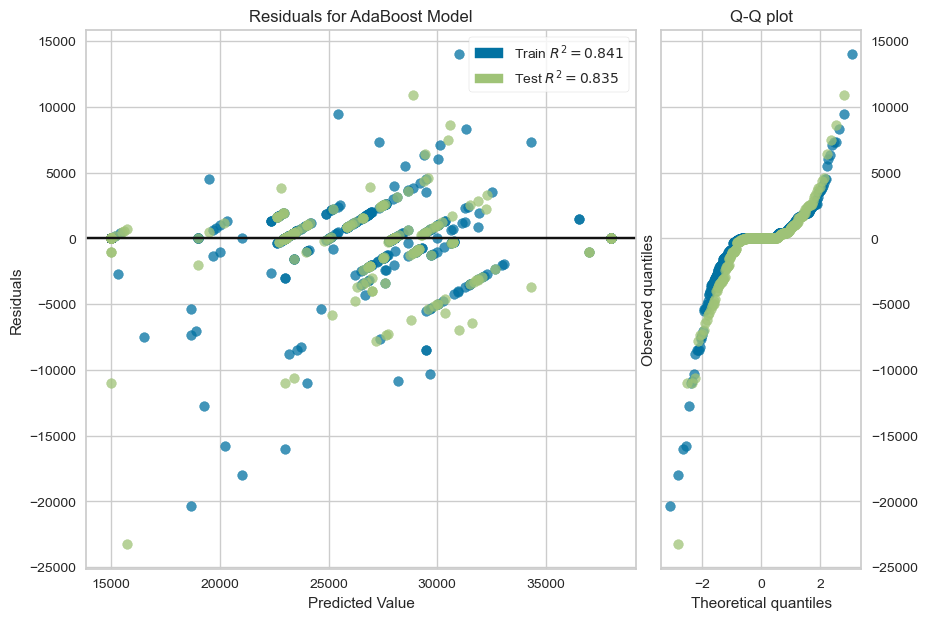

In [148]:
from yellowbrick.regressor import residuals_plot
fig, ax = plt.subplots(figsize=(10, 7))
_ = residuals_plot(estimator=ada_grid.best_estimator_,
                   is_fitted=True,
                   ax=ax,
                   X_train=X_train,
                   y_train=y_train,
                   X_test=X_test,
                   y_test=y_test,
                   hist=False,
                   qqplot=True,
                  title="Residuals for AdaBoost Model"
                  )


# XGBoost


In [81]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [82]:
xg_boost = xgb.XGBRegressor(random_state=42,
                           n_estimators=50,
                           subsample=0.9,
                           max_depth=5,
                           learning_rate=0.1,
                           gamma=0)

In [83]:
xg_boost.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 50,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 42,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [84]:
xg_boost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [85]:
pred = xg_boost.predict(X_test)

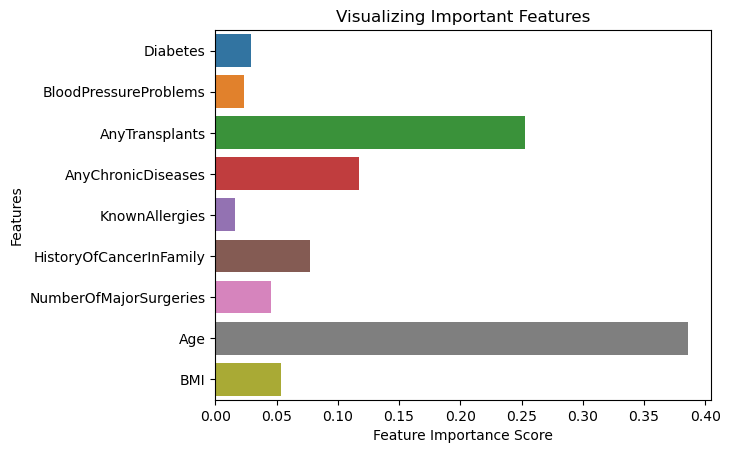

In [86]:
feature_imp1 = xg_boost.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.savefig('my_plot.png')
plt.show()

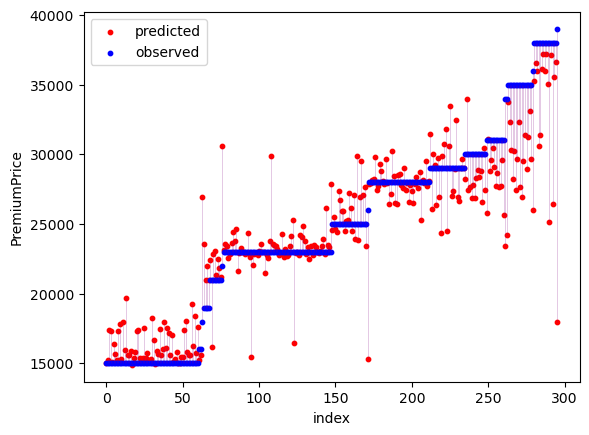

In [87]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

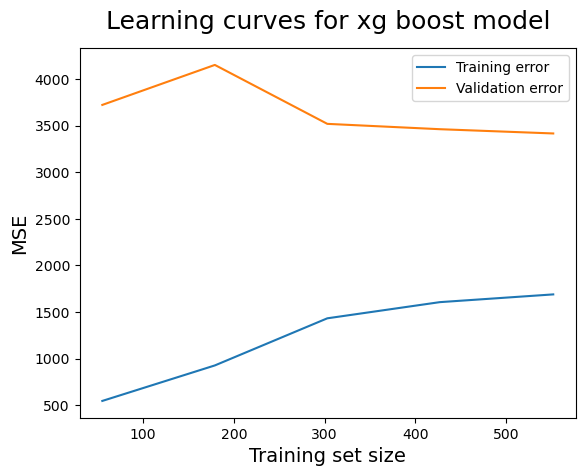

In [88]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = xg_boost,
X = X_train,
y = y_train,
    cv = 5,
scoring = 'neg_mean_squared_error')

train_scores = np.sqrt(-train_scores)
validation_scores = np.sqrt(-validation_scores)

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for xg boost model', fontsize = 18, y = 1.03)
plt.legend()

In [89]:
summary.loc[3] = eval(xg_boost, "XGBoost")
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3253.892554,368.533617
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3594.299697,331.585182
3,XGBoost,3083.932345,1855.948128,7.347068,4.350488,3526.810959,298.613790


## grid search

In [94]:
param_grid = {
    'n_estimators': [150, 200, 250],
    'max_depth': [4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'eta': [0.1, 0.01, 0.001]
}

In [95]:
grid_xg_boost = xgb.XGBRegressor(random_state=42)

In [96]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
xg_grid = GridSearchCV(grid_xg_boost, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=2)

In [97]:
score = xg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [98]:
score.best_params_

{'eta': 0.01, 'max_depth': 4, 'n_estimators': 250, 'subsample': 0.7}

In [99]:
eval(score.best_estimator_, "grid xg boost")

{'model': 'grid xg boost',
 'test_rmse': 3120.262737820964,
 'train_rmse': 2702.5887618423417,
 'test_mape': 8.341499397419591,
 'train_mape': 7.30447094597531,
 'cv_rmse': 3376.735743478006,
 'cv_rmse_std': 312.31049729228056}

In [100]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3253.892554,368.533617
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3594.299697,331.585182
3,XGBoost,3083.932345,1855.948128,7.347068,4.350488,3526.810959,298.613790


In [101]:
best_estimator = score.best_estimator_
pred = best_estimator.predict(X_test)
xgBoost_test_r2=r2_score(y_test,pred)
xgBoost_test_r2

0.7779373959909416

In [102]:
xgBoost_train_r2=r2_score(y_train,best_estimator.predict(X_train))
xgBoost_train_r2

0.8016976549172934

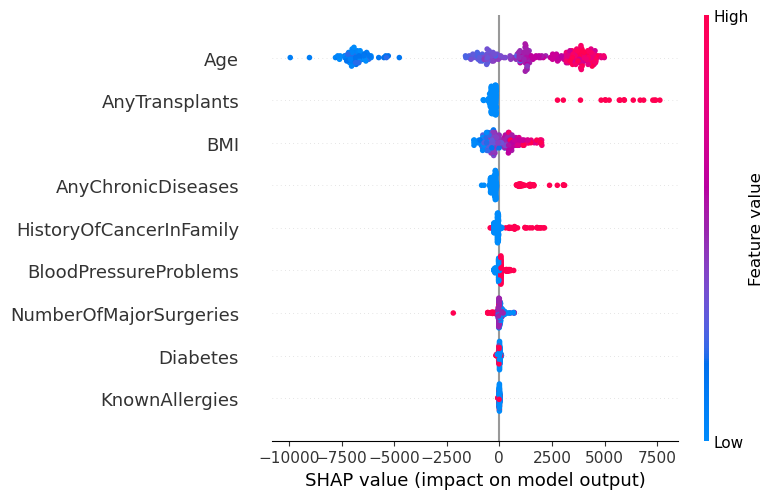

In [103]:
import shap
explainer1 = shap.TreeExplainer(xg_grid.best_estimator_)
xg_shap_values = explainer1.shap_values(X_test)
shap.summary_plot(xg_shap_values, X_test)

# Gradient boosting

In [60]:
from sklearn.ensemble import GradientBoostingRegressor

In [61]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [62]:
gbm = GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, min_samples_leaf=2, max_depth=5, random_state=42)

In [63]:
gbm.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=5, min_samples_leaf=2,
                          n_estimators=300, random_state=42)

In [64]:
pred = gbm.predict(X_test)

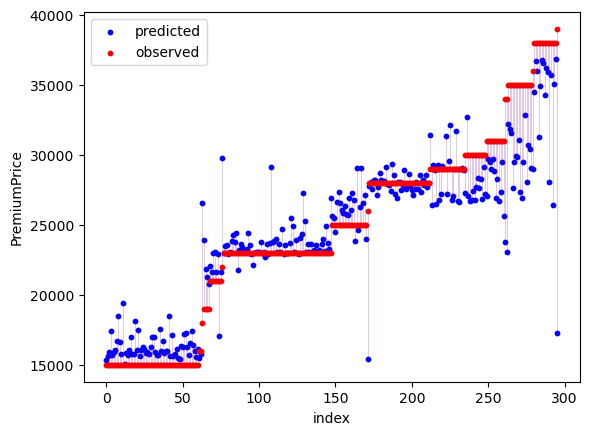

In [65]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [66]:
eval(gbm, "gradient boosting")

{'model': 'gradient boosting',
 'test_rmse': 2911.0973191391604,
 'train_rmse': 2227.8922725775415,
 'test_mape': 7.001216221573009,
 'train_mape': 5.572097405695333,
 'cv_rmse': 3374.9555962938093,
 'cv_rmse_std': 501.88440484763765}

## Grid search

In [67]:
gbm = GradientBoostingRegressor(random_state=42)

In [75]:
gbm.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [85]:
param_grid = {
    'max_depth': [4],
    'max_features': [None, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [250, 300, 350],
    'subsample': [0.8, 0.5, 1]
}

In [86]:
forest_grid = GridSearchCV(estimator = gbm, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [87]:
score = forest_grid.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [88]:
score.best_estimator_

GradientBoostingRegressor(max_depth=4, max_features=4, min_samples_leaf=3,
                          n_estimators=250, random_state=42, subsample=1)

In [89]:
score.best_params_

{'max_depth': 4,
 'max_features': 4,
 'min_samples_leaf': 3,
 'n_estimators': 250,
 'subsample': 1}

In [90]:
eval(score.best_estimator_, "gbm")

{'model': 'gbm',
 'test_rmse': 2926.140952391152,
 'train_rmse': 1447.586091861718,
 'test_mape': 6.924735134745992,
 'train_mape': 3.668047769766384,
 'cv_rmse': 3562.307725983669,
 'cv_rmse_std': 495.4424109984849}

In [91]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2769.426625,2420.005995,6.296463,5.326606,3216.522692,605.101768


# Stacking

## attempt1

In [100]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [101]:
from sklearn.model_selection import RepeatedKFold

In [102]:
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 return models

In [103]:
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
 return np.sqrt(-scores)

In [104]:
models = get_models()

>knn 4255.198 (579.644)
>cart 3833.525 (922.851)
>svm 6359.471 (513.949)


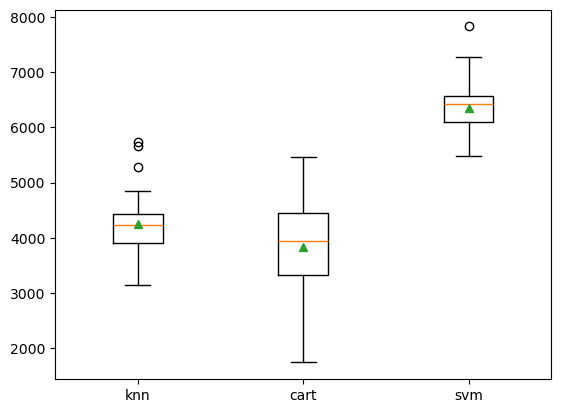

In [105]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [106]:
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 models['stacking'] = get_stacking()
 return models

In [107]:
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('knn', KNeighborsRegressor()))
 level0.append(('cart', DecisionTreeRegressor()))
 level0.append(('svm', SVR()))
 # define meta learner model
 level1 = LinearRegression()
 # define the stacking ensemble
 model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
 return model

>knn 3988.537 (594.969)
>cart 4434.881 (917.590)
>svm 6132.304 (462.552)
>stacking 3751.995 (642.448)


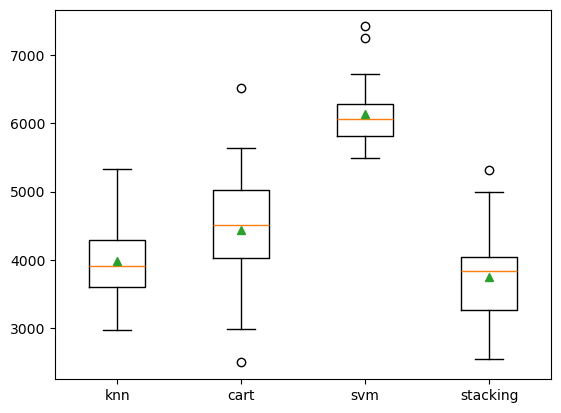

In [108]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## attempt2

In [109]:
level0 = list()
level0.append(('forest', RandomForestRegressor(random_state=42)))
level0.append(('xgboost', xgb.XGBRegressor()))

level1 = LinearRegression()

stacked_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [110]:
models = dict()
models["forest"] = RandomForestRegressor(random_state=42)
models["xgboost"] = xgb.XGBRegressor()
models["stacking"] = stacked_model

In [111]:
models

{'forest': RandomForestRegressor(random_state=42),
 'xgboost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...),
 'stacking': StackingRegressor(cv=5,
                   estimators=[('forest',
                                RandomForestRegressor(random_state=42)),
                               ('

>forest 3410.852 (732.343)
>xgboost 3695.487 (719.970)
>stacking 3409.276 (700.973)


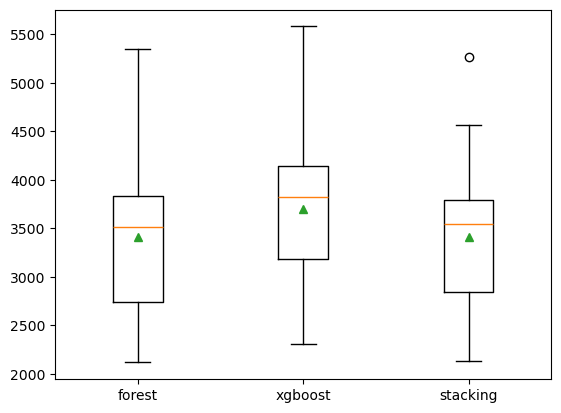

In [112]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## attemp3

In [113]:
level0 = list()
level0.append(('forest', forest_reg))
level0.append(('adaboost', ada_boost))

level1 = LinearRegression()

stacked_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [114]:
models = dict()
models["forest"] = forest_reg
models['adaboost'] = ada_boost
models["stacking"] = stacked_model

>forest 3190.640 (784.163)
>adaboost 3149.627 (866.340)
>stacking 3144.094 (808.921)


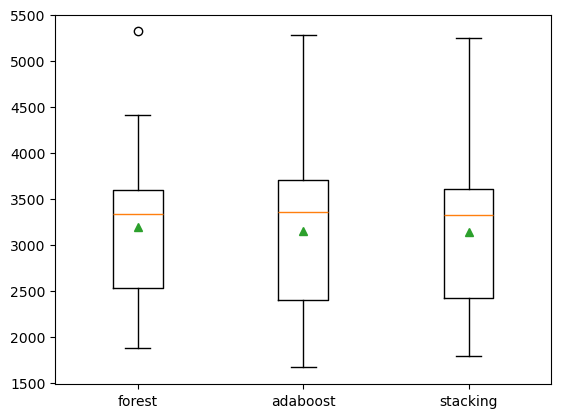

In [115]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

# Cluster wise model fitting

In [93]:
def evalc(model, name, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))

    mape_test = mean_absolute_percentage_error(y_test, pred_test)*100
    mape_train = mean_absolute_percentage_error(y_train, pred_train)*100

    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=cv)
    scores = np.sqrt(-scores)
    cv_mean = np.mean(scores)
    cv_std = np.std(scores)

    row = {'model': name,
           'test_rmse': rmse_test,
           'train_rmse': rmse_train,
           'test_mape': mape_test,
           'train_mape': mape_train,
           'cv_rmse': cv_mean,
           'cv_rmse_std': cv_std}
    return row

In [94]:
pipec = clone(pipe)
pipec = clone(pipe).set_params(**{'cluster__drop': False})

In [95]:
cluster1 = dt[dt.cluster == 1]
cluster2 = dt[dt.cluster == 2]
cluster3 = dt[dt.cluster == 3]

## cluster1

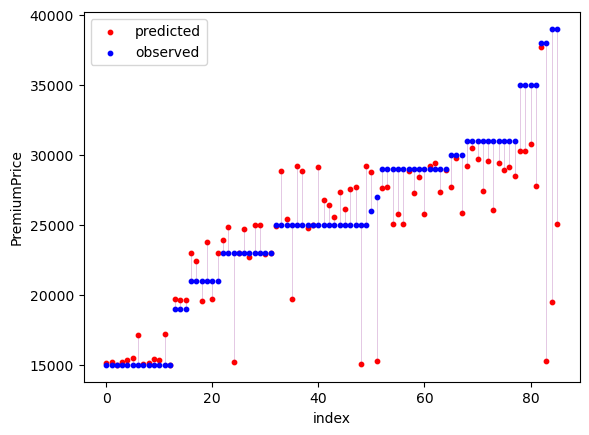

In [96]:
X_c1 = cluster1.drop(["PremiumPrice", "cluster"], axis=1)
y_c1 = cluster1.PremiumPrice
x_c1_train, x_c1_test, y_c1_train, y_c1_test = train_test_split(X_c1, y_c1, test_size=0.3, random_state=42)
X_c1_train = pipec.fit_transform(x_c1_train)
X_c1_test = pipec.fit_transform(x_c1_test)

c1forest_reg = RandomForestRegressor(random_state=42, max_depth=5, n_estimators=300, n_jobs=-1, min_samples_leaf=2)
c1forest_reg.fit(X_c1_train, y_c1_train)

pred_c1_test = c1forest_reg.predict(X_c1_test)
pred_c1_train = c1forest_reg.predict(X_c1_train)

temp = pd.DataFrame({'Observed':y_c1_test, 'predicted':pred_c1_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [97]:
evalc(c1forest_reg, "c1 forest", X_c1_train, X_c1_test, y_c1_train, y_c1_test)

{'model': 'c1 forest',
 'test_rmse': 4625.867253659728,
 'train_rmse': 2073.0970020192835,
 'test_mape': 9.314992098766423,
 'train_mape': 5.529626627313942,
 'cv_rmse': 2780.9972575803595,
 'cv_rmse_std': 561.9176952358973}

## cluster2

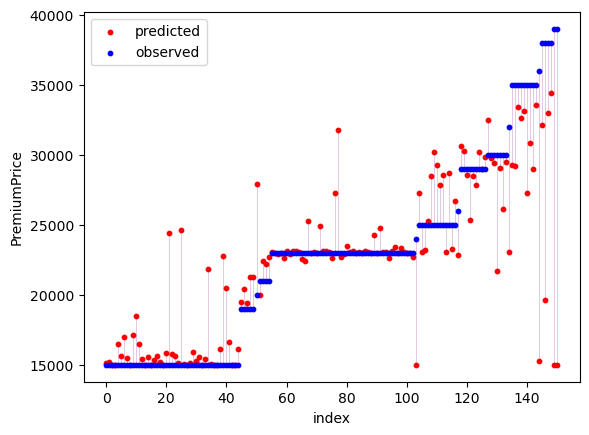

In [98]:
X_c2 = cluster2.drop(["PremiumPrice", "cluster"], axis=1)
y_c2 = cluster2.PremiumPrice
x_c2_train, x_c2_test, y_c2_train, y_c2_test = train_test_split(X_c2, y_c2, test_size=0.3, random_state=42)
X_c2_train = pipec.fit_transform(x_c2_train)
X_c2_test = pipec.fit_transform(x_c2_test)

c2forest_reg = RandomForestRegressor(random_state=42, max_depth=6, n_estimators=300, n_jobs=-1, min_samples_leaf=2)
c2forest_reg.fit(X_c2_train, y_c2_train)

pred_c2_test = c2forest_reg.predict(X_c2_test)
pred_c2_train = c2forest_reg.predict(X_c2_train)

temp = pd.DataFrame({'Observed':y_c2_test, 'predicted':pred_c2_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [99]:
evalc(c2forest_reg, "c2 forest", X_c2_train, X_c2_test, y_c2_train, y_c2_test)

{'model': 'c2 forest',
 'test_rmse': 4551.982067144961,
 'train_rmse': 2061.1701461067914,
 'test_mape': 8.68172630692278,
 'train_mape': 3.6531915786748357,
 'cv_rmse': 2771.697073160152,
 'cv_rmse_std': 1164.8714877485809}

## cluster3

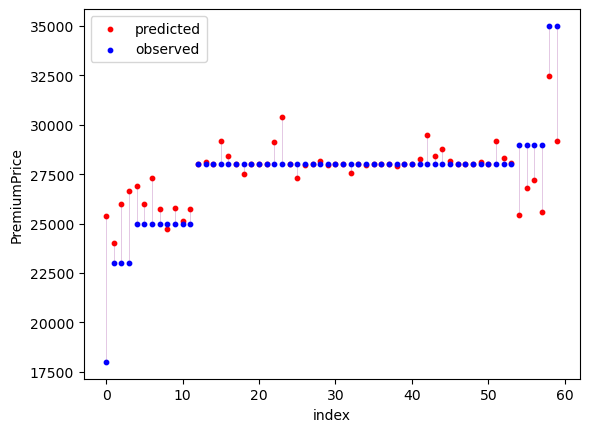

In [100]:
X_c3 = cluster3.drop(["PremiumPrice", "cluster"], axis=1)
y_c3 = cluster3.PremiumPrice
x_c3_train, x_c3_test, y_c3_train, y_c3_test = train_test_split(X_c3, y_c3, test_size=0.3, random_state=42)
X_c3_train = pipec.fit_transform(x_c3_train)
X_c3_test = pipec.fit_transform(x_c3_test)

c3forest_reg = RandomForestRegressor(random_state=42, max_depth=6, n_estimators=300, n_jobs=-1, min_samples_leaf=2)
c3forest_reg.fit(X_c3_train, y_c3_train)

pred_c3_test = c3forest_reg.predict(X_c3_test)
pred_c3_train = c3forest_reg.predict(X_c3_train)

temp = pd.DataFrame({'Observed':y_c3_test, 'predicted':pred_c3_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [101]:
evalc(c3forest_reg, "c3 forest", X_c3_train, X_c3_test, y_c3_train, y_c3_test)

{'model': 'c3 forest',
 'test_rmse': 1714.0538170050886,
 'train_rmse': 1413.038240619892,
 'test_mape': 3.507049005692777,
 'train_mape': 2.5041370049483347,
 'cv_rmse': 2235.091158030042,
 'cv_rmse_std': 1060.9512781514186}

In [104]:
X_c1_train.shape + X_c2_train.shape + X_c3_train.shape

(199, 9, 350, 9, 140, 9)

In [125]:
y_c1_test.shape + y_c2_test.shape + y_c3_test.shape

(86, 151, 60)

In [126]:
dfc1 = pd.DataFrame({'test_observed':y_c1_test,
              'test_predicted':pred_c1_test,})
dfc1.reset_index(drop=True, inplace=True)

dfc2 = pd.DataFrame({'test_observed':y_c2_test,
              'test_predicted':pred_c2_test})
dfc2.reset_index(drop=True, inplace=True)

dfc3 = pd.DataFrame({'test_observed':y_c3_test,
              'test_predicted':pred_c3_test})
dfc3.reset_index(drop=True, inplace=True)

dfc = pd.concat([dfc1, dfc2, dfc3])

In [127]:
np.sqrt(mean_squared_error(dfc.test_observed, dfc.test_predicted))

4162.266038118342

In [128]:
dfc1 = pd.DataFrame({'train_observed':y_c1_train,
              'train_predicted':pred_c1_train,})
dfc1.reset_index(drop=True, inplace=True)

dfc2 = pd.DataFrame({'train_observed':y_c2_train,
              'train_predicted':pred_c2_train})
dfc2.reset_index(drop=True, inplace=True)

dfc3 = pd.DataFrame({'train_observed':y_c3_train,
              'train_predicted':pred_c3_train})
dfc3.reset_index(drop=True, inplace=True)

dfc = pd.concat([dfc1, dfc2, dfc3])

In [129]:
np.sqrt(mean_squared_error(dfc.train_observed, dfc.train_predicted))

1950.672960585465

# Adding cluster label

In [130]:
pipec = clone(pipe).set_params(**{'cluster__drop': False,
                                 'oneHot__columns': ["cluster"]})

In [131]:
X_train = pipec.fit_transform(x_train.copy())
X_test = pipec.fit_transform(x_test.copy())

## Random Forest

In [132]:
nforest_reg = RandomForestRegressor(max_depth=6, n_estimators=300, min_samples_leaf=2, random_state=42, n_jobs=-1)

In [133]:
nforest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [134]:
pred = nforest_reg.predict(X_test)

In [135]:
eval(nforest_reg, 'random forest2')

{'model': 'random forest2',
 'test_rmse': 2770.993660434782,
 'train_rmse': 2414.251008674677,
 'test_mape': 6.300340029634521,
 'train_mape': 5.33338641750395,
 'cv_rmse': 3219.179445729342,
 'cv_rmse_std': 603.8355840841236}

In [136]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2769.426625,2420.005995,6.296463,5.326606,3216.522692,605.101768
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543
2,AdaBoost,2695.114327,2278.660585,4.234093,3.602639,3218.553748,597.505380
3,XGBoost,3122.064487,2166.599023,7.540181,5.434179,3534.844505,502.168099


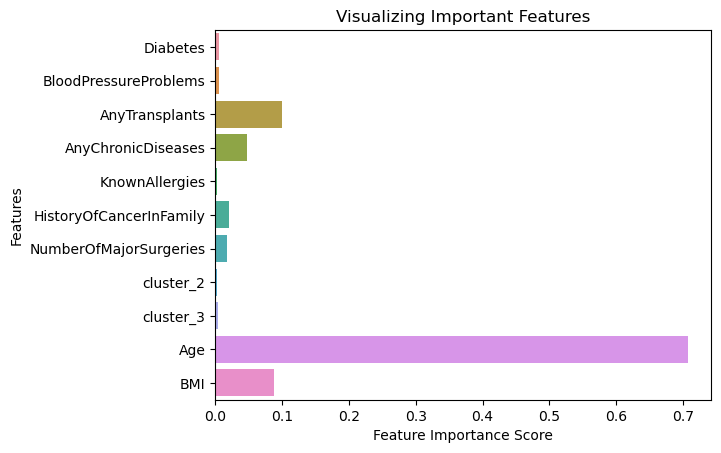

In [137]:
feature_imp1 = nforest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

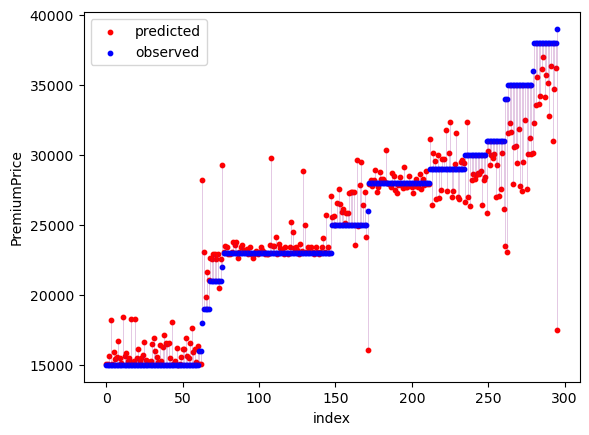

In [138]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## xgboost

In [139]:
nxgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=5, eta=0.01,
                         subsample=0.5, colsample_bytree=0.5, gamma=0)

In [140]:
nxgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [141]:
pred = nxgb_reg.predict(X_test)

In [142]:
eval(nxgb_reg, "xgboost2")

{'model': 'xgboost2',
 'test_rmse': 3022.0096844733903,
 'train_rmse': 2031.0671680245587,
 'test_mape': 7.422968854404307,
 'train_mape': 5.2440409521101214,
 'cv_rmse': 3421.557832359923,
 'cv_rmse_std': 476.3193915899515}

In [143]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2769.426625,2420.005995,6.296463,5.326606,3216.522692,605.101768
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543
2,AdaBoost,2695.114327,2278.660585,4.234093,3.602639,3218.553748,597.505380
3,XGBoost,3122.064487,2166.599023,7.540181,5.434179,3534.844505,502.168099


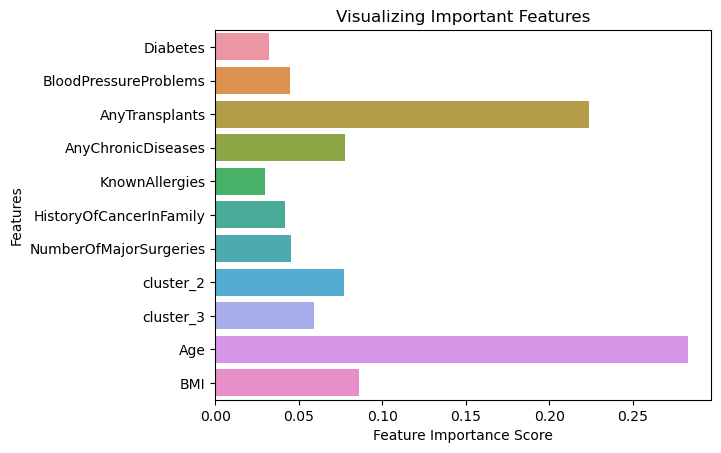

In [144]:
feature_imp1 = nxgb_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

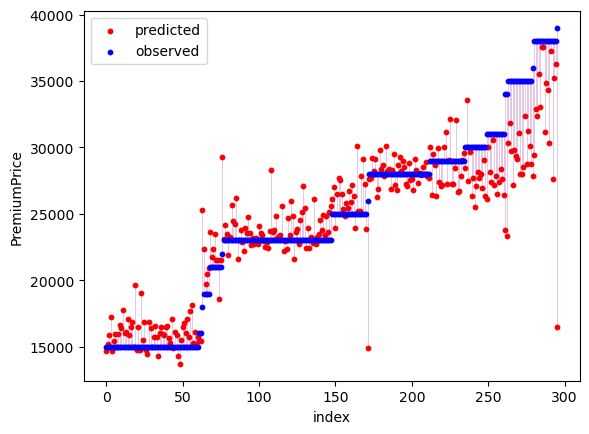

In [145]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## AdaBoost

In [146]:
nada_boost = AdaBoostRegressor(n_estimators=200, base_estimator=tree_reg, learning_rate=0.001, random_state=42)

In [147]:
nada_boost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       min_samples_leaf=2,
                                                       random_state=42),
                  learning_rate=0.001, n_estimators=200, random_state=42)

In [148]:
eval(nada_boost, "adaboost")

{'model': 'adaboost',
 'test_rmse': 2701.5758776957737,
 'train_rmse': 2292.077333161312,
 'test_mape': 4.238417624445258,
 'train_mape': 3.6111605391650494,
 'cv_rmse': 3234.6035736414406,
 'cv_rmse_std': 592.0108441858846}

In [149]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2769.426625,2420.005995,6.296463,5.326606,3216.522692,605.101768
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543
2,AdaBoost,2695.114327,2278.660585,4.234093,3.602639,3218.553748,597.505380
3,XGBoost,3122.064487,2166.599023,7.540181,5.434179,3534.844505,502.168099


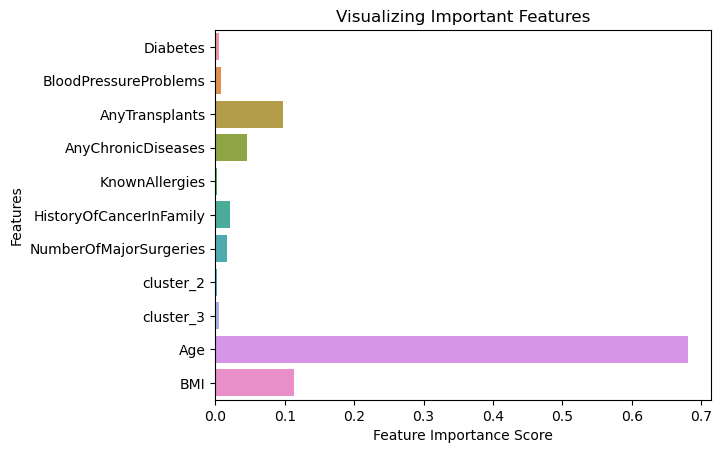

In [150]:
feature_imp1 = nada_boost.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Factor Analysis Components Regression

In [151]:
fct = pd.read_csv("factor.csv")

In [152]:
X = fct.copy()

In [153]:
y = df.PremiumPrice.copy()

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Random forest

In [155]:
forest_reg = RandomForestRegressor()

In [156]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [157]:
pred = forest_reg.predict(X_test)

In [162]:
eval(forest_reg, 'forest_reg')

{'model': 'forest_reg',
 'test_rmse': 3405.993603083016,
 'train_rmse': 1417.0770929309544,
 'test_mape': 9.997804672596773,
 'train_mape': 3.925201126011512,
 'cv_rmse': 3894.9769228669074,
 'cv_rmse_std': 430.88000213680334}

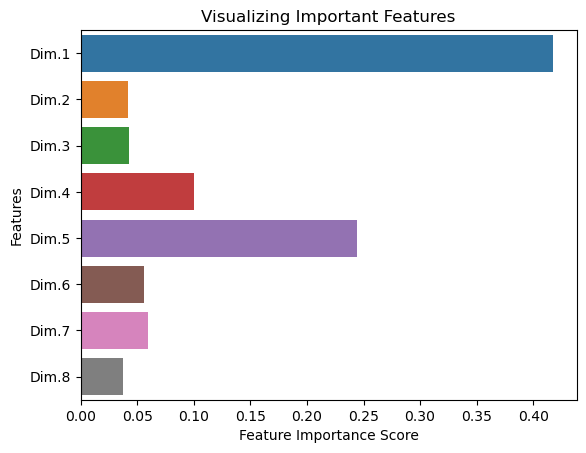

In [163]:
feature_imp1 = forest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

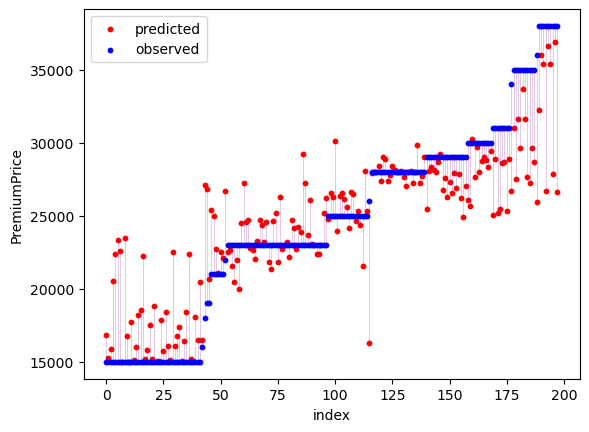

In [164]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## XGBoost

In [165]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1,
                         subsample=0.7, colsample_bytree=0.8)

In [166]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [167]:
pred = xgb_reg.predict(X_test)

In [168]:
eval(xgb_reg, 'xgb_reg')

{'model': 'xgb_reg',
 'test_rmse': 3514.1452270275063,
 'train_rmse': 0.01701180258344998,
 'test_mape': 10.58428304821413,
 'train_mape': 5.548591899809031e-05,
 'cv_rmse': 3921.7466652345165,
 'cv_rmse_std': 358.57426924588617}

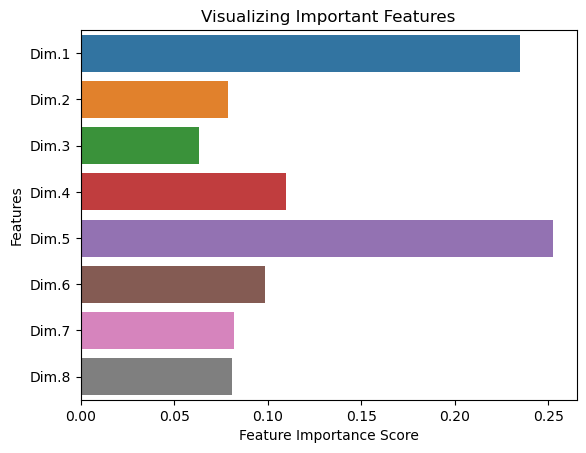

In [169]:
feature_imp1 = xgb_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

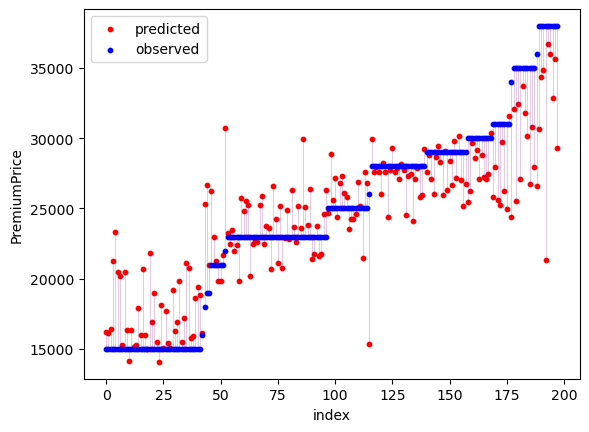

In [170]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

# upsampled

# experiment

In [183]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

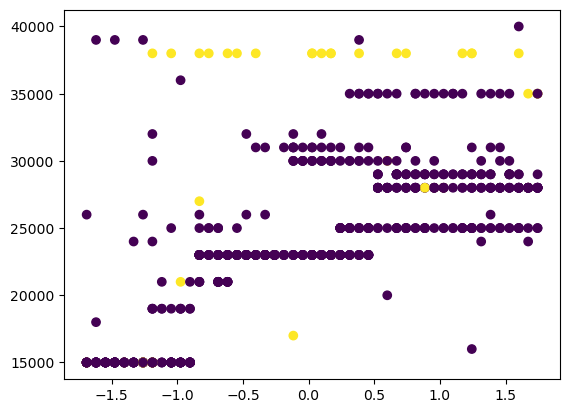

In [105]:
plt.scatter(X_train.Age, y_train, c=X_train.AnyTransplants)